# Evaluation of models

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

X_train = pd.read_csv("../data/processed/X_train.csv")
X_val = pd.read_csv("../data/processed/X_val.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
y_val = pd.read_csv("../data/processed/y_val.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

target_variable = "tree_type"

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "Random Forest": RandomForestClassifier(max_depth=10, n_estimators=10),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gaussian NB": GaussianNB(),
    "Bernoulli NB": BernoulliNB(),
}

# Fit models
for name, model in models.items():
    model.fit(X_train, y_train[target_variable])

## Classification Metrics Foundation: Beyond Accuracy

Concept: Accuracy tells you "how often you're right" but hides crucial details about different types of errors. Understanding precision, recall, and F1-score reveals exactly where your model succeeds and fails.

In [2]:
def basic_metrics(model, X_test, y_test):
    """Calculate fundamental classification metrics"""
    y_pred = model.predict(X_test)

    # Get confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (
        2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    )

    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-Score:  {f1:.3f}")

    return accuracy, precision, recall, f1


# Print evaluation metrics for each model
for name, model in models.items():
    print(f"\n{name} Evaluation:")
    basic_metrics(model, X_test, y_test[target_variable])


Logistic Regression Evaluation:
Accuracy:  0.843
Precision: 0.827
Recall:    0.827
F1-Score:  0.827

Decision Tree Evaluation:
Accuracy:  0.880
Precision: 0.868
Recall:    0.867
F1-Score:  0.868

Random Forest Evaluation:
Accuracy:  0.894
Precision: 0.878
Recall:    0.890
F1-Score:  0.884

SVM Evaluation:
Accuracy:  0.849
Precision: 0.822
Recall:    0.850
F1-Score:  0.836

KNN Evaluation:
Accuracy:  0.911
Precision: 0.895
Recall:    0.912
F1-Score:  0.903

Gaussian NB Evaluation:
Accuracy:  0.643
Precision: 0.676
Recall:    0.408
F1-Score:  0.508

Bernoulli NB Evaluation:
Accuracy:  0.718
Precision: 0.688
Recall:    0.693
F1-Score:  0.690


## Confusion Matrix: Your Model's Report Card

Concept: The confusion matrix is your model's detailed report card, showing exactly which classes get confused with which others. This visual tool reveals patterns that single metrics miss.


Logistic Regression Confusion Matrix:


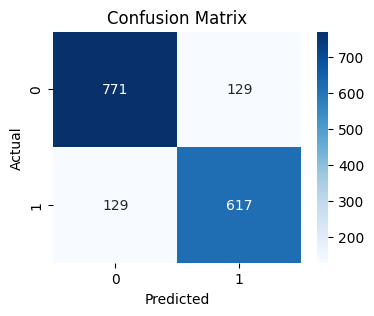

Total samples: 1646
Accuracy: 0.843

Decision Tree Confusion Matrix:


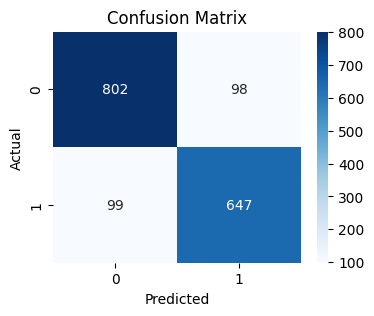

Total samples: 1646
Accuracy: 0.880

Random Forest Confusion Matrix:


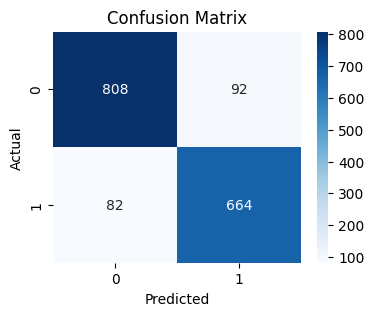

Total samples: 1646
Accuracy: 0.894

SVM Confusion Matrix:


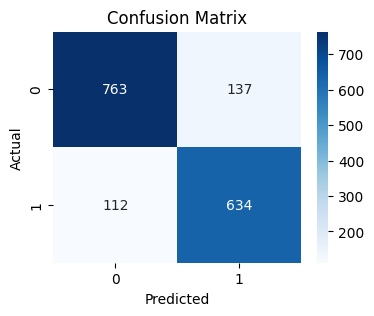

Total samples: 1646
Accuracy: 0.849

KNN Confusion Matrix:


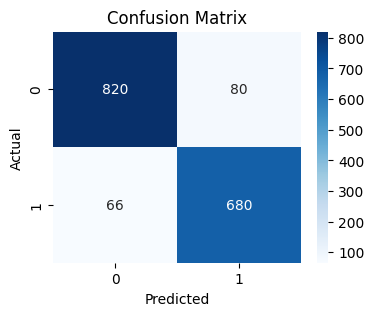

Total samples: 1646
Accuracy: 0.911

Gaussian NB Confusion Matrix:


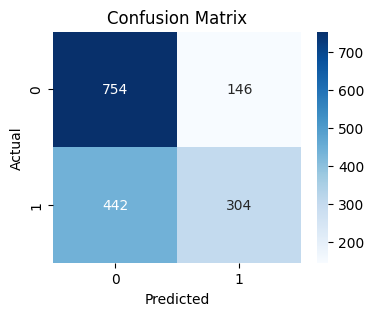

Total samples: 1646
Accuracy: 0.643

Bernoulli NB Confusion Matrix:


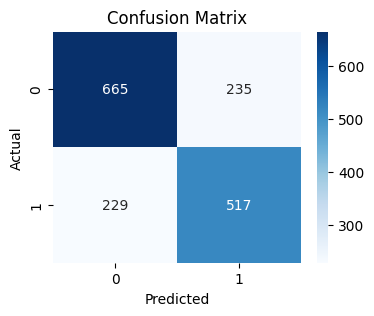

Total samples: 1646
Accuracy: 0.718


In [3]:
def plot_confusion_matrix(model, X_test, y_test):
    """Create clear confusion matrix visualization"""
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Simple analysis
    total = cm.sum()
    accuracy = (cm[0, 0] + cm[1, 1]) / total
    print(f"Total samples: {total}")
    print(f"Accuracy: {accuracy:.3f}")

    return cm


# Plot confusion matrix for each model
for name, model in models.items():
    print(f"\n{name} Confusion Matrix:")
    plot_confusion_matrix(model, X_test, y_test[target_variable])

## ROC Curves and AUC: Threshold-Independent Evaluation

Concept: ROC curves show how your model performs across all possible decision thresholds, while AUC provides a single score summarizing this performance. This is crucial for understanding your model's fundamental discriminative ability.


Logistic Regression ROC Curve:


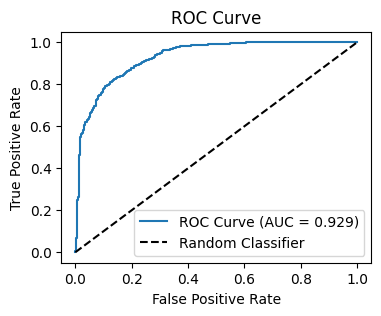


Decision Tree ROC Curve:


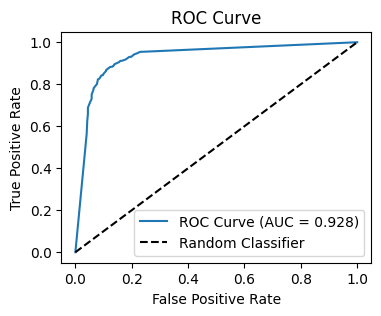


Random Forest ROC Curve:


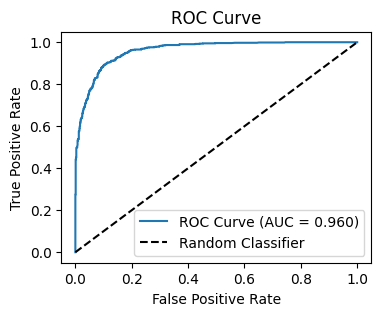


KNN ROC Curve:


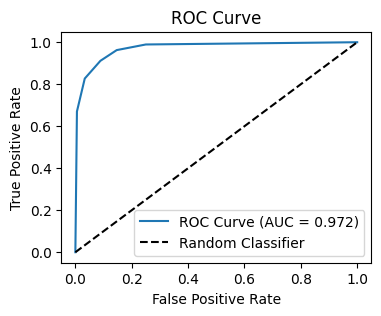


Gaussian NB ROC Curve:


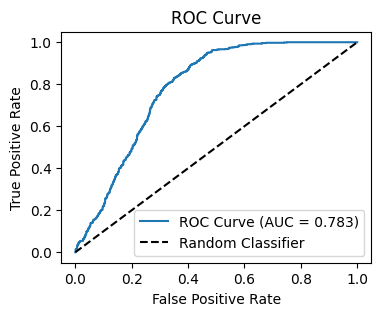


Bernoulli NB ROC Curve:


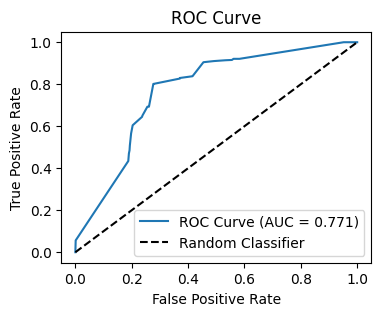

In [4]:
def simple_roc_analysis(model, X_test, y_test):
    """Simple ROC curve analysis"""
    # Get probabilities
    y_proba = model.predict_proba(X_test)[:, 1]

    y_test_for_roc = y_test.copy()

    # Convert string labels to binary (e.g., 'deciduous' = 1, 'coniferous' = 0)
    y_true = (
        y_test_for_roc.map({"coniferous": 0, "deciduous": 1})
        if isinstance(y_test_for_roc, pd.Series)
        else y_test_for_roc.apply(lambda x: 1 if x == "deciduous" else 0)
    )

    # Calculate ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return roc_auc


# Plot ROC curve for each model
for name, model in models.items():
    if name != "SVM":  # SVM does not support predict_proba by default
        print(f"\n{name} ROC Curve:")
        simple_roc_analysis(model, X_test, y_test[target_variable])

## Precision-Recall Curves: Focus on the Positive Class

Concept: When you care most about correctly identifying the positive class (especially in imbalanced datasets), precision-recall curves provide more insights than ROC curves by focusing specifically on positive class performance.

We will test if Precision-Recall curves are more informative than ROC curves for our dataset --> The tests shows that ROC curves are sufficient for our relatively balanced dataset.

In [5]:
def choose_curve_type(y_test):
    """Decide which curve is more informative"""
    # Map string labels to binary: 'deciduous' = 1, 'coniferous' = 0
    y_binary = y_test.map({"coniferous": 0, "deciduous": 1})
    positive_rate = y_binary.mean()

    if positive_rate < 0.1:
        return "Use Precision-Recall: Highly imbalanced dataset"
    elif positive_rate < 0.3:
        return "Use both curves: Moderately imbalanced"
    else:
        return "ROC sufficient: Relatively balanced classes"


# Usage
recommendation = choose_curve_type(y_test[target_variable])
print(recommendation)

ROC sufficient: Relatively balanced classes


## Cross-Validation: Reliable Performance Estimation

Concept: Single train-test splits can be misleading due to lucky or unlucky data partitions. Cross-validation provides robust performance estimates by testing your model multiple ways.

In [6]:
def reliable_cv_evaluation(model, X, y):
    """Simple but robust cross-validation"""
    # Use stratified k-fold for balanced splits
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Test multiple metrics
    accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring="f1_weighted")

    print("Cross-Validation Results:")
    print(f"Accuracy: {accuracy_scores.mean():.3f} ± {accuracy_scores.std():.3f}")
    print(f"F1-Score: {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")

    # Check consistency
    if accuracy_scores.std() > 0.05:
        print("⚠️ High variance - model performance is inconsistent")
    else:
        print("✅ Stable performance across folds")


# Evaluate each model with cross-validation
for name, model in models.items():
    print(f"\n{name} Cross-Validation:")
    reliable_cv_evaluation(
        model,
        pd.concat([X_train, X_val]),
        pd.concat([y_train[target_variable], y_val[target_variable]]),
    )


Logistic Regression Cross-Validation:
Cross-Validation Results:
Accuracy: 0.830 ± 0.010
F1-Score: 0.830 ± 0.010
✅ Stable performance across folds

Decision Tree Cross-Validation:
Cross-Validation Results:
Accuracy: 0.875 ± 0.006
F1-Score: 0.875 ± 0.007
✅ Stable performance across folds

Random Forest Cross-Validation:
Cross-Validation Results:
Accuracy: 0.895 ± 0.005
F1-Score: 0.898 ± 0.005
✅ Stable performance across folds

SVM Cross-Validation:
Cross-Validation Results:
Accuracy: 0.846 ± 0.010
F1-Score: 0.846 ± 0.010
✅ Stable performance across folds

KNN Cross-Validation:
Cross-Validation Results:
Accuracy: 0.917 ± 0.006
F1-Score: 0.917 ± 0.006
✅ Stable performance across folds

Gaussian NB Cross-Validation:
Cross-Validation Results:
Accuracy: 0.655 ± 0.010
F1-Score: 0.637 ± 0.010
✅ Stable performance across folds

Bernoulli NB Cross-Validation:
Cross-Validation Results:
Accuracy: 0.742 ± 0.022
F1-Score: 0.742 ± 0.022
✅ Stable performance across folds


## Error Analysis: Understanding Model Failures

Concept: Systematic error analysis reveals patterns in your model's mistakes, guiding targeted improvements. By understanding what causes errors, you can enhance feature engineering or model selection.

In [7]:
def analyze_errors(model, X_test, y_test):
    """Find patterns in model errors"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Identify errors
    errors = y_test != y_pred

    print(f"Error Rate: {errors.mean():.3f}")
    print(f"Total Errors: {errors.sum()} / {len(y_test)}")

    # Confidence analysis
    max_confidence = y_proba.max(axis=1)
    correct_confidence = max_confidence[~errors].mean()
    error_confidence = max_confidence[errors].mean()

    print(f"Average confidence (correct): {correct_confidence:.3f}")
    print(f"Average confidence (errors): {error_confidence:.3f}")

    # Low confidence predictions
    low_confidence = max_confidence < 0.6
    print(
        f"Low confidence predictions: {low_confidence.sum()} ({low_confidence.mean():.1%})"
    )


def feature_error_patterns(X_test, y_test, y_pred, top_features):
    """Analyze how features relate to errors"""
    errors = y_test != y_pred

    print("Feature Analysis for Errors:")
    for feature in top_features[:3]:  # Top 3 features
        correct_mean = X_test[feature][~errors].mean()
        error_mean = X_test[feature][errors].mean()

        print(f"\n{feature}:")
        print(f"  Correct predictions: {correct_mean:.3f}")
        print(f"  Error predictions: {error_mean:.3f}")
        print(f"  Difference: {abs(correct_mean - error_mean):.3f}")


def confidence_strategy(model, X_test, confidence_threshold=0.8):
    """Design confidence-based business strategy"""
    y_proba = model.predict_proba(X_test)
    max_confidence = y_proba.max(axis=1)

    high_confidence = max_confidence >= confidence_threshold
    low_confidence = max_confidence < confidence_threshold

    print(f"Business Strategy (threshold: {confidence_threshold}):")
    print(
        f"Auto-process: {high_confidence.sum()} samples ({high_confidence.mean():.1%})"
    )
    print(
        f"Manual review: {low_confidence.sum()} samples ({low_confidence.mean():.1%})"
    )
    print(f"Workload reduction: {high_confidence.mean():.1%}")


for name, model in models.items():
    if name != "SVM":  # SVM does not support predict_proba by default
        print("\n")
        print("=" * 50)
        print(f"{name} Error Analysis:")
        analyze_errors(model, X_test, y_test[target_variable])

        y_pred = model.predict(X_test)
        top_features = (
            X_train.columns.tolist()
        )  # Assuming all features are important for simplicity
        feature_error_patterns(X_test, y_test[target_variable], y_pred, top_features)

        confidence_strategy(model, X_test, confidence_threshold=0.8)



Logistic Regression Error Analysis:
Error Rate: 0.157
Total Errors: 258 / 1646
Average confidence (correct): 0.870
Average confidence (errors): 0.692
Low confidence predictions: 161 (9.8%)
Feature Analysis for Errors:

age:
  Correct predictions: -0.082
  Error predictions: -0.166
  Difference: 0.084

average_height:
  Correct predictions: -0.124
  Error predictions: -0.282
  Difference: 0.158

dbh:
  Correct predictions: -0.118
  Error predictions: -0.249
  Difference: 0.131
Business Strategy (threshold: 0.8):
Auto-process: 1092 samples (66.3%)
Manual review: 554 samples (33.7%)
Workload reduction: 66.3%


Decision Tree Error Analysis:
Error Rate: 0.120
Total Errors: 197 / 1646
Average confidence (correct): 0.958
Average confidence (errors): 0.827
Low confidence predictions: 60 (3.6%)
Feature Analysis for Errors:

age:
  Correct predictions: -0.081
  Error predictions: -0.199
  Difference: 0.118

average_height:
  Correct predictions: -0.122
  Error predictions: -0.344
  Difference:

## Model Calibration: Understanding Prediction Confidence

Concept: Well-calibrated models produce probability estimates that match real-world frequencies. A model saying "80% confident" should be correct about 80% of the time.


Logistic Regression Calibration Check:


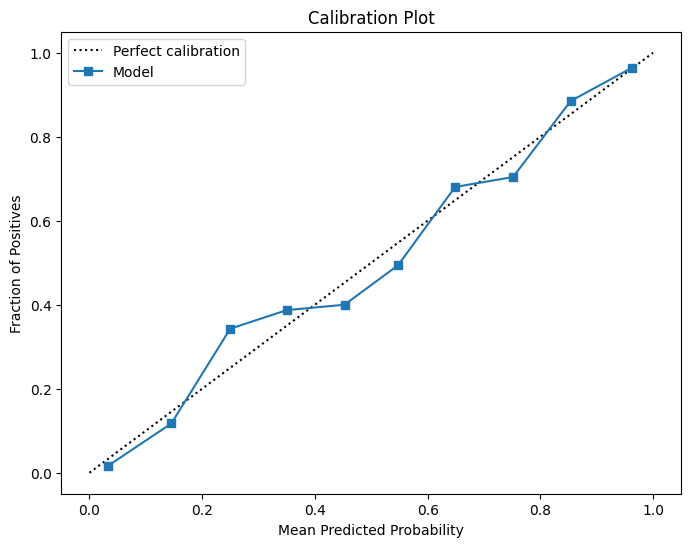

Calibration Error: 0.039
✅ Well calibrated

Decision Tree Calibration Check:


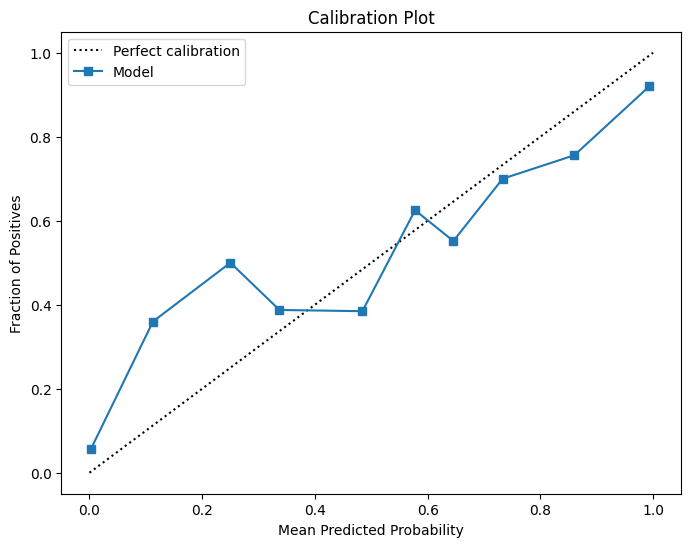

Calibration Error: 0.105
🔴 Poorly calibrated

Random Forest Calibration Check:


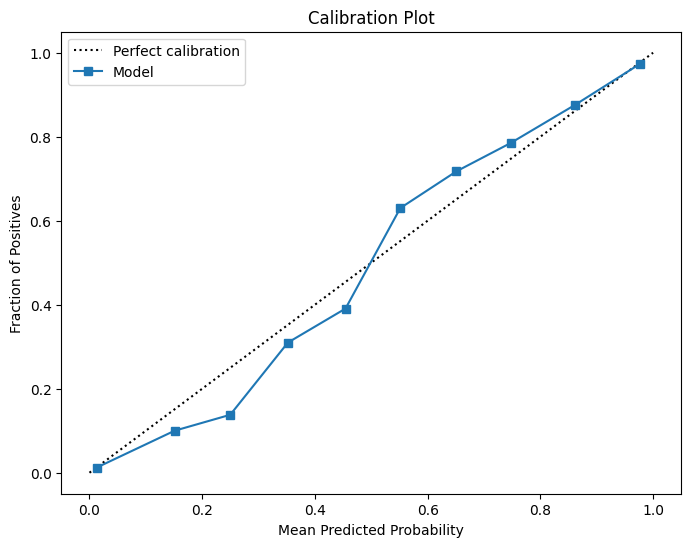

Calibration Error: 0.047
✅ Well calibrated

KNN Calibration Check:


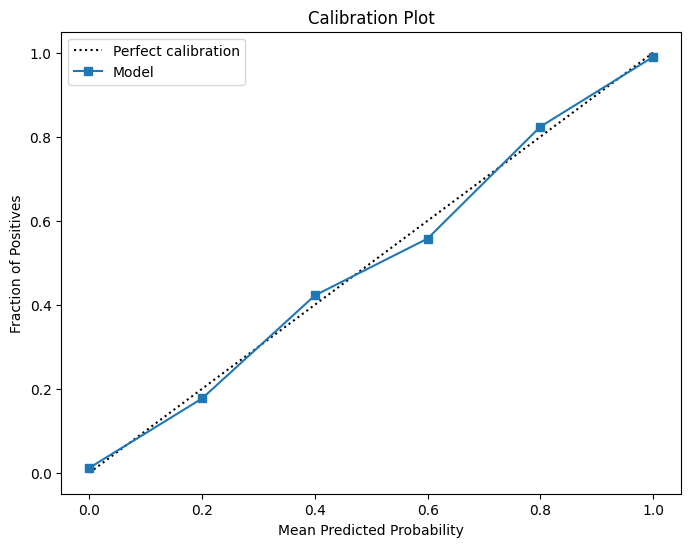

Calibration Error: 0.022
✅ Well calibrated

Gaussian NB Calibration Check:


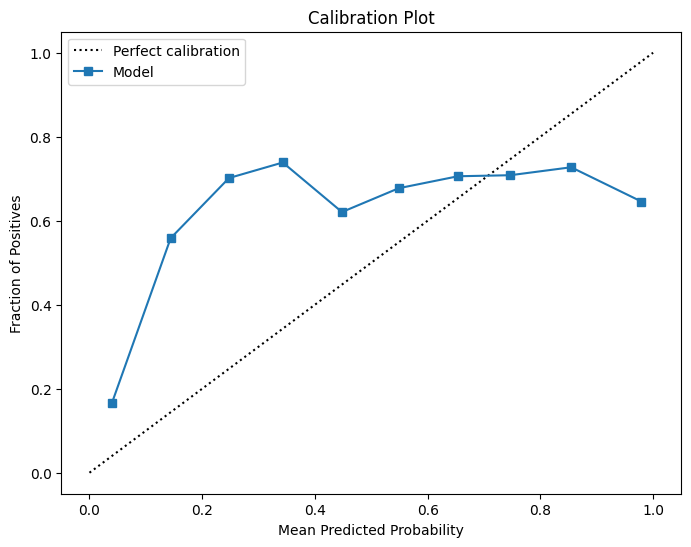

Calibration Error: 0.224
🔴 Poorly calibrated

Bernoulli NB Calibration Check:


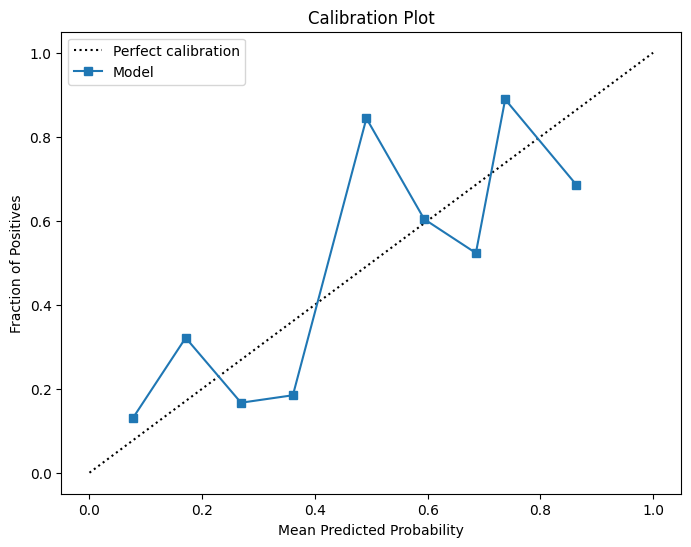

Calibration Error: 0.149
🔴 Poorly calibrated


In [8]:
def check_calibration(model, X_test, y_test):
    """Simple calibration analysis"""
    y_proba = model.predict_proba(X_test)[:, 1]

    # Convert string labels to binary: 'deciduous' = 1, 'coniferous' = 0
    if isinstance(y_test, pd.DataFrame):
        y_true = y_test.iloc[:, 0].map({"coniferous": 0, "deciduous": 1})
    else:
        y_true = y_test.map({"coniferous": 0, "deciduous": 1})

    # Calculate calibration
    fraction_positives, mean_predicted = calibration_curve(y_true, y_proba, n_bins=10)

    # Plot calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], "k:", label="Perfect calibration")
    plt.plot(mean_predicted, fraction_positives, "s-", label="Model")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Plot")
    plt.legend()
    plt.show()

    # Calculate calibration error
    calibration_error = abs(fraction_positives - mean_predicted).mean()
    print(f"Calibration Error: {calibration_error:.3f}")

    if calibration_error < 0.05:
        print("✅ Well calibrated")
    elif calibration_error < 0.1:
        print("⚠️ Reasonably calibrated")
    else:
        print("🔴 Poorly calibrated")


for name, model in models.items():
    if name != "SVM":  # SVM does not support predict_proba by default
        print(f"\n{name} Calibration Check:")
        check_calibration(model, X_test, y_test)

## Business-Aligned Evaluation Metrics

Concept: Technical metrics like accuracy don't always align with business value. Creating custom metrics that reflect real business costs and benefits leads to better model selection decisions.

This is not really relevant for this project, since there are no direct business implications. The key goal is that a third party auditor (like TÜV) accepts the data provided by the model.

## Model Interpretability and Explainability

Concept: Understanding why your model makes specific predictions builds trust and enables better business decisions. Different interpretation methods suit different model types and business needs.

In [9]:
def analyze_feature_importance(model, X_test, feature_names):
    """Extract and analyze feature importance"""

    # Method 1: Built-in importance (for tree-based models)
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
        method = "Built-in importance"
    elif hasattr(model, "coef_"):
        importance = abs(model.coef_[0])
        method = "Coefficient magnitude"
    else:
        print("Model doesn't have built-in feature importance")
        return None

    # Create importance ranking
    feature_importance = list(zip(feature_names, importance))
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    print(f"Feature Importance ({method}):")
    for i, (feature, imp) in enumerate(feature_importance[:10]):
        print(f"{i+1:2d}. {feature}: {imp:.4f}")

    return feature_importance


for name, model in models.items():
    print(f"\n{name} Feature Importance:")
    analyze_feature_importance(model, X_test, X_test.columns.tolist())


Logistic Regression Feature Importance:
Feature Importance (Coefficient magnitude):
 1. basal_area: 5.4640
 2. average_height: 3.2770
 3. age: 1.4922
 4. dbh: 0.9058
 5. trees_per_ha: 0.0174

Decision Tree Feature Importance:
Feature Importance (Built-in importance):
 1. basal_area: 0.5385
 2. trees_per_ha: 0.1696
 3. age: 0.1445
 4. average_height: 0.1120
 5. dbh: 0.0355

Random Forest Feature Importance:
Feature Importance (Built-in importance):
 1. basal_area: 0.4879
 2. trees_per_ha: 0.1726
 3. age: 0.1472
 4. average_height: 0.1099
 5. dbh: 0.0824

SVM Feature Importance:
Model doesn't have built-in feature importance

KNN Feature Importance:
Model doesn't have built-in feature importance

Gaussian NB Feature Importance:
Model doesn't have built-in feature importance

Bernoulli NB Feature Importance:
Model doesn't have built-in feature importance


In [10]:
def bootstrap_confidence_intervals(model, X_test, y_test, n_bootstrap=1000):
    """Calculate confidence intervals for performance metrics"""

    bootstrap_scores = []

    for i in range(n_bootstrap):
        # Bootstrap sample
        X_boot, y_boot = resample(X_test, y_test, random_state=i)

        # Calculate metric
        y_pred_boot = model.predict(X_boot)
        score = accuracy_score(y_boot, y_pred_boot)
        bootstrap_scores.append(score)

    # Calculate confidence intervals
    confidence_level = 0.95
    alpha = 1 - confidence_level
    lower = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)
    mean_score = np.mean(bootstrap_scores)

    print(f"Bootstrap Confidence Interval ({confidence_level:.0%}):")
    print(f"Mean Accuracy: {mean_score:.3f}")
    print(f"95% CI: [{lower:.3f}, {upper:.3f}]")

    return mean_score, (lower, upper)


for name, model in models.items():
    print(f"\n{name} Bootstrap Confidence Intervals:")
    bootstrap_confidence_intervals(model, X_test, y_test[target_variable], 100)


Logistic Regression Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.844
95% CI: [0.828, 0.863]

Decision Tree Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.881
95% CI: [0.868, 0.896]

Random Forest Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.894
95% CI: [0.878, 0.908]

SVM Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.849
95% CI: [0.831, 0.866]

KNN Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.911
95% CI: [0.899, 0.925]

Gaussian NB Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.642
95% CI: [0.622, 0.658]

Bernoulli NB Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.717
95% CI: [0.696, 0.737]
